### Prédiction en Time series

Dans cette partie, nous allons de réaliser une analyse en time series du retard des trains.
Dans la logique de la consigne, nous devons prédire le retard moyens des trains dans les mois de 2023, nous décidons donc de nous considérer pour l'entrainement comme étant le 31 décembre 2022, avec toutes les données historique. C'est pour cette raison que nous allons devoir retirer du dataset de test toutes les features que nous ne pouvons pas avoir au 31 decembre 2022


Ainsi, nous allons conserver uniquement la date, les gares de départ et d'arrivée ainsi que le nombre de trains prévus (nous supposons que cette donnée est disponible quelques mois à l'avance)

Nous allons ensuite conserver les features à prédire : le retard moyen à l'arrivée ainsi que les causes

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
import math
import warnings
import logging
import cmdstanpy

In [2]:
your_path = r"C:\Users\MatyG\Documents\2023_2024\ApprAuto"

df = pd.read_csv(your_path + r'\Apprentissage_Automatique_Project\Python_files\csv_files\regularite-mensuelle-tgv-aqst.csv',sep=';')
df.columns

Index(['date', 'service', 'gare_depart', 'gare_arrivee', 'duree_moyenne',
       'nb_train_prevu', 'nb_annulation', 'commentaire_annulation',
       'nb_train_depart_retard', 'retard_moyen_depart',
       'retard_moyen_tous_trains_depart', 'commentaire_retards_depart',
       'nb_train_retard_arrivee', 'retard_moyen_arrivee',
       'retard_moyen_tous_trains_arrivee', 'commentaires_retard_arrivee',
       'nb_train_retard_sup_15', 'retard_moyen_trains_retard_sup15',
       'nb_train_retard_sup_30', 'nb_train_retard_sup_60',
       'prct_cause_externe', 'prct_cause_infra', 'prct_cause_gestion_trafic',
       'prct_cause_materiel_roulant', 'prct_cause_gestion_gare',
       'prct_cause_prise_en_charge_voyageurs'],
      dtype='object')

In [3]:
df_for_timeseries = df[["date", 
                        "gare_depart", 
                        "gare_arrivee", 
                        "nb_train_prevu",
                        "retard_moyen_tous_trains_arrivee",
                        'prct_cause_externe', 
                        'prct_cause_infra', 
                        'prct_cause_gestion_trafic',
                        'prct_cause_materiel_roulant', 
                        'prct_cause_gestion_gare',
                        'prct_cause_prise_en_charge_voyageurs']]

df_for_timeseries

,date,gare_depart,gare_arrivee,nb_train_prevu,retard_moyen_tous_trains_arrivee,prct_cause_externe,prct_cause_infra,prct_cause_gestion_trafic,prct_cause_materiel_roulant,prct_cause_gestion_gare,prct_cause_prise_en_charge_voyageurs
0,2018-01,BORDEAUX ST JEAN,PARIS MONTPARNASSE,870,6.511118,36.134454,31.092437,10.924370,15.966387,5.042017,0.840336
1,2018-01,LA ROCHELLE VILLE,PARIS MONTPARNASSE,222,5.696096,15.384615,30.769231,38.461538,11.538462,3.846154,0.000000
2,2018-01,PARIS MONTPARNASSE,QUIMPER,248,7.578947,26.923077,38.461538,15.384615,19.230769,0.000000,0.000000
3,2018-01,PARIS MONTPARNASSE,ST MALO,102,6.790686,23.076923,46.153846,7.692308,15.384615,7.692308,0.000000
4,2018-01,PARIS MONTPARNASSE,ST PIERRE DES CORPS,391,3.346487,21.212121,42.424242,9.090909,21.212121,6.060606,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
8149,2023-06,STRASBOURG,PARIS EST,492,7.689898,7.619048,5.714286,55.238095,18.095238,7.619048,5.714286
8150,2023-06,TOULOUSE MATABIAU,PARIS MONTPARNASSE,215,14.824264,13.888889,33.333333,8.333333,19.444444,8.333333,16.666667
8151,2023-06,TOURS,PARIS MONTPARNASSE,192,8.650349,14.285714,21.428571,28.571429,21.428571,3.571429,10.714286
8152,2023-06,VALENCE ALIXAN TGV,PARIS LYON,440,12.765753,26.724138,19.827586,27.586207,7.758621,7.758621,10.344828


Pour une première analyse en timeseries, nous allons chercher à prédir uniquement le retard moyen.
Nous devons séparer le dataset en groupes, correspondant à chaque trajet. En effet, l'analyse en timeseries doit etre entrainée pour chaque trajet.

Créons les trajets :

In [4]:
df_pred_retard = df_for_timeseries[["date", 
                                    "gare_depart", 
                                    "gare_arrivee", 
                                    "nb_train_prevu",
                                    "retard_moyen_tous_trains_arrivee",
                                    ]]

df_pred_retard = df_pred_retard.assign(trajet=df_pred_retard["gare_depart"] + " - " + df_pred_retard["gare_arrivee"])

Réalisons l'analyse time series sur un premier trajet : Paris Montparnasse - Bordeaux Saint Jean

In [5]:
df_paris_bordeaux = df_pred_retard[df_pred_retard["trajet"]=="PARIS MONTPARNASSE - BORDEAUX ST JEAN"].reset_index(drop=True)
df_paris_bordeaux

,date,gare_depart,gare_arrivee,nb_train_prevu,retard_moyen_tous_trains_arrivee,trajet
0,2018-01,PARIS MONTPARNASSE,BORDEAUX ST JEAN,775,2.546962,PARIS MONTPARNASSE - BORDEAUX ST JEAN
1,2018-02,PARIS MONTPARNASSE,BORDEAUX ST JEAN,698,10.113599,PARIS MONTPARNASSE - BORDEAUX ST JEAN
2,2018-03,PARIS MONTPARNASSE,BORDEAUX ST JEAN,760,2.415507,PARIS MONTPARNASSE - BORDEAUX ST JEAN
3,2018-04,PARIS MONTPARNASSE,BORDEAUX ST JEAN,756,2.377624,PARIS MONTPARNASSE - BORDEAUX ST JEAN
4,2018-05,PARIS MONTPARNASSE,BORDEAUX ST JEAN,800,2.380243,PARIS MONTPARNASSE - BORDEAUX ST JEAN
...,...,...,...,...,...,...
61,2023-02,PARIS MONTPARNASSE,BORDEAUX ST JEAN,920,2.324686,PARIS MONTPARNASSE - BORDEAUX ST JEAN
62,2023-03,PARIS MONTPARNASSE,BORDEAUX ST JEAN,1035,4.061302,PARIS MONTPARNASSE - BORDEAUX ST JEAN
63,2023-04,PARIS MONTPARNASSE,BORDEAUX ST JEAN,1007,4.467371,PARIS MONTPARNASSE - BORDEAUX ST JEAN
64,2023-05,PARIS MONTPARNASSE,BORDEAUX ST JEAN,918,3.620593,PARIS MONTPARNASSE - BORDEAUX ST JEAN


Dans un premier temps, nous allons faire une analyse time series simple, sans paramètres supplémentaires (uniquement la date (step) et la feature à predire)

In [6]:
mini_df_paris_bordeaux = df_paris_bordeaux[["date", "retard_moyen_tous_trains_arrivee"]].rename(columns={"retard_moyen_tous_trains_arrivee":"retard"})

Affichons cette série

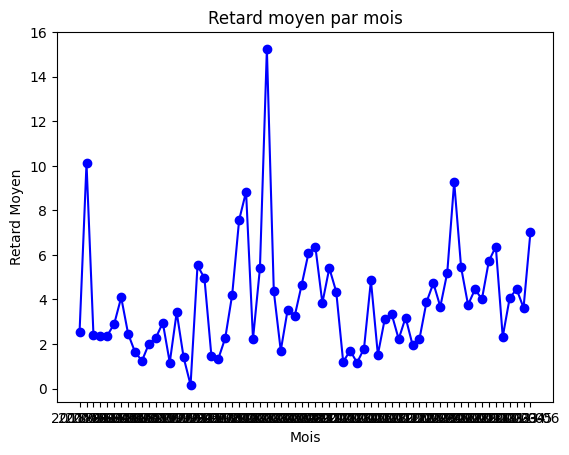

In [7]:
plt.plot(mini_df_paris_bordeaux["date"], mini_df_paris_bordeaux["retard"], marker='o', linestyle='-', color='b')
plt.xlabel('Mois')
plt.ylabel('Retard Moyen')
plt.title('Retard moyen par mois')
plt.show()

Pour la prédiction, nous allons utiliser le modele Prophet developpé par meta, il est connu pour son efficacité et sa simplicité d'utilisation.

In [8]:
mini_df_paris_bordeaux["date"] = pd.to_datetime(mini_df_paris_bordeaux["date"])

train = (
    mini_df_paris_bordeaux[mini_df_paris_bordeaux["date"]<="2022-12"]
        .rename(
            columns={
                "date": "ds", #Renomages obligatoire pour utiliser prophet
                "retard":"y",
            }
        )
)

test = (
    mini_df_paris_bordeaux[mini_df_paris_bordeaux["date"] >= "2023-01"]
        .rename(
            columns={
                "date": "ds",
                "retard":"y",
            }
        )
        .reset_index(drop=True)
)
test

,ds,y
0,2023-01-01,6.369695
1,2023-02-01,2.324686
2,2023-03-01,4.061302
3,2023-04-01,4.467371
4,2023-05-01,3.620593
5,2023-06-01,7.042505


In [9]:
model = Prophet()
model.fit(train)

17:21:58 - cmdstanpy - INFO - Chain [1] start processing
17:21:59 - cmdstanpy - INFO - Chain [1] done processing


In [10]:
test["pred"] = model.predict(test[["ds"]])["yhat"]

test

,ds,y,pred
0,2023-01-01,6.369695,6.176048
1,2023-02-01,2.324686,4.535782
2,2023-03-01,4.061302,4.851062
3,2023-04-01,4.467371,1.741356
4,2023-05-01,3.620593,3.104722
5,2023-06-01,7.042505,7.127149


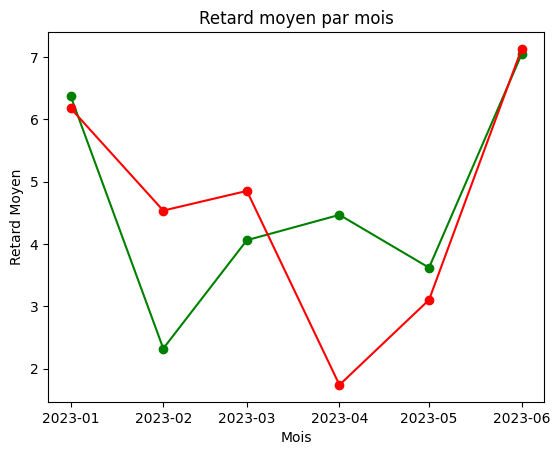

In [11]:
plt.plot(test["ds"], test["y"], marker='o', linestyle='-', color='g')
plt.plot(test["ds"], test["pred"], marker='o', linestyle='-', color='r')
plt.xlabel('Mois')
plt.ylabel('Retard Moyen')
plt.title('Retard moyen par mois')
plt.show()

In [12]:
MSE = np.square(np.subtract(test["y"],test["pred"])).mean() 
 
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n")
print(RMSE)

Root Mean Square Error:

1.4863050436504581


La justesse du résultat est difficile à estimer, nous allons donc réaliser la meme opération sur l'ensemble des trajets. Pour cela nous allons créer une fonction rassemblant toutes les opérations précédentes

In [5]:
def GetSimpleForecast(df, trajet):
    with warnings.catch_warnings():
        # Filtrer le DataFrame pour le 'trajet' spécifié et sélectionner les colonnes pertinentes
        df_trajet = df[df["trajet"] == trajet][["date", "retard_moyen_tous_trains_arrivee"]]
        df_trajet = df_trajet.rename(columns={"date": "ds", "retard_moyen_tous_trains_arrivee": "y"})

        # Convertir la colonne 'ds' en datetime
        df_trajet['ds'] = pd.to_datetime(df_trajet['ds'])

        # Diviser le jeu de données en ensembles d'entraînement et de test
        train = df_trajet[df_trajet["ds"] <= "2022-12"]
        test = df_trajet[df_trajet["ds"] >= "2023-01"].reset_index(drop=True)

        # Initialiser et entraîner le modèle Prophet
        model = Prophet()
        model.fit(train)

        # Effectuer des prédictions pour l'ensemble de test
        test = test.assign(pred=model.predict(test[['ds']])['yhat'])

        # Calculer le RMSE
        mse = np.mean((test["y"] - test["pred"])**2)
        rmse = math.sqrt(mse)

    return test, rmse

In [6]:
res, rmse = GetSimpleForecast(df_pred_retard, "PARIS MONTPARNASSE - BORDEAUX ST JEAN")

print(rmse)
res

17:41:50 - cmdstanpy - INFO - Chain [1] start processing
17:41:50 - cmdstanpy - INFO - Chain [1] done processing


1.4863050436504581


,ds,y,pred
0,2023-01-01,6.369695,6.176048
1,2023-02-01,2.324686,4.535782
2,2023-03-01,4.061302,4.851062
3,2023-04-01,4.467371,1.741356
4,2023-05-01,3.620593,3.104722
5,2023-06-01,7.042505,7.127149


On applique maintenant cette fonction pour tous les trajets du dataset

In [8]:
#Retrait des commentaires d'execution de prophet
logging.getLogger('Prophet').setLevel(logging.WARNING)
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)

global_test = pd.DataFrame()
rmses = {}
for trajet in df_pred_retard["trajet"].unique() :
    try :
        test, rmse = GetSimpleForecast(df_pred_retard, trajet)

        global_test = pd.concat([global_test, test], axis=0)
        rmses[trajet] = rmse
            
    except :
        print("PROBLEM WITH", trajet)

print(rmses)
global_test

PROBLEM WITH PARIS VAUGIRARD - NANTES
PROBLEM WITH RENNES - PARIS VAUGIRARD
PROBLEM WITH MADRID - MARSEILLE ST CHARLES
PROBLEM WITH NANTES - PARIS VAUGIRARD
PROBLEM WITH TOURCOING - MARSEILLE ST CHARLES
PROBLEM WITH MARSEILLE ST CHARLES - MADRID
PROBLEM WITH BORDEAUX ST JEAN - PARIS VAUGIRARD
PROBLEM WITH PARIS VAUGIRARD - BORDEAUX ST JEAN
PROBLEM WITH PARIS VAUGIRARD - RENNES
{'BORDEAUX ST JEAN - PARIS MONTPARNASSE': 2.8544669880452838, 'LA ROCHELLE VILLE - PARIS MONTPARNASSE': 2.7549045222604103, 'PARIS MONTPARNASSE - QUIMPER': 4.071992817927029, 'PARIS MONTPARNASSE - ST MALO': 2.5140454912755827, 'PARIS MONTPARNASSE - ST PIERRE DES CORPS': 1.531944696344728, 'QUIMPER - PARIS MONTPARNASSE': 3.2008441859486, 'RENNES - LYON PART DIEU': 6.284652882094995, 'ST PIERRE DES CORPS - PARIS MONTPARNASSE': 2.4740015002641926, 'TOURS - PARIS MONTPARNASSE': 1.8457881047469726, 'NANTES - STRASBOURG': 5.800366327434939, 'PARIS EST - STRASBOURG': 2.031264751459173, 'STRASBOURG - PARIS EST': 6.194798

,ds,y,pred
0,2023-01-01,6.065343,8.381100
1,2023-02-01,3.920701,6.062580
2,2023-03-01,5.552626,8.164355
3,2023-04-01,7.724143,2.615315
4,2023-05-01,5.464684,4.860744
...,...,...,...
1,2023-02-01,4.706149,3.278890
2,2023-03-01,8.091714,-1.040719
3,2023-04-01,7.259865,1.044844
4,2023-05-01,3.547307,5.024429


In [12]:
global_mse = np.mean((global_test["y"] - global_test["pred"])**2)
global_rmse = math.sqrt(global_mse)

print("RMSE globale :", global_rmse)

RMSE globale : 4.924462749946295


In [13]:
max(list(rmses.values()))
#On observe des résultats de rmse aberrants

24.53155480851126

In [18]:
for k, v in rmses.items() :
    if v > 6:
        print(k)

RENNES - LYON PART DIEU
STRASBOURG - PARIS EST
BORDEAUX ST JEAN - TOURCOING
TOURCOING - BORDEAUX ST JEAN
MONTPELLIER - PARIS LYON
PARIS EST - FRANCFORT
STRASBOURG - NANTES
PARIS LYON - BARCELONA
GRENOBLE - PARIS LYON
NIMES - PARIS LYON
LYON PART DIEU - RENNES
MARSEILLE ST CHARLES - TOURCOING


Nous allons étudier la raison des erreurs en vérifiant que chaque trajet possède bien un nombre de mois necessaire

In [28]:
value_counts = df_pred_retard['trajet'].value_counts()
result_df = pd.DataFrame({'trajet': value_counts.index, 'Nombre de mois': value_counts.values})

display(result_df[result_df["Nombre de mois"] < 66])

,trajet,Nombre de mois
116,MARSEILLE ST CHARLES - TOURCOING,65
117,ZURICH - PARIS LYON,65
118,PARIS LYON - ZURICH,65
119,BORDEAUX ST JEAN - TOURCOING,64
120,TOURCOING - BORDEAUX ST JEAN,64
121,MARSEILLE ST CHARLES - MADRID,45
122,MADRID - MARSEILLE ST CHARLES,45
123,TOURCOING - MARSEILLE ST CHARLES,13
124,PARIS VAUGIRARD - NANTES,12
125,PARIS VAUGIRARD - RENNES,12


In [10]:
#Verifions que les mis manquant ne sont pas dans le test (rendant impossible le calcul de performance de la prediction)

toutes_les_valeurs = df_pred_retard['trajet'].unique()
df_2023 = df_pred_retard[df_pred_retard["date"]>"2022-12-01"]
value_counts = df_2023['trajet'].value_counts()
result = pd.DataFrame(pd.Series(value_counts, index=toutes_les_valeurs).fillna(0).astype(int))

display(result[result["count"]!=6])

,count
PARIS VAUGIRARD - NANTES,0
RENNES - PARIS VAUGIRARD,0
MADRID - MARSEILLE ST CHARLES,0
NANTES - PARIS VAUGIRARD,0
TOURCOING - MARSEILLE ST CHARLES,0
MARSEILLE ST CHARLES - MADRID,0
BORDEAUX ST JEAN - PARIS VAUGIRARD,0
PARIS VAUGIRARD - BORDEAUX ST JEAN,0
PARIS VAUGIRARD - RENNES,0


In [11]:
# On supprime ces data car inutilisables, on observe que ce sont les 9 qui n"ont pas été determinées par prophet
to_drop = list(result[result["count"]!=6].index)
df_pred_retard = df_pred_retard[~df_pred_retard['trajet'].isin(to_drop)]

df_pred_retard

,date,gare_depart,gare_arrivee,nb_train_prevu,retard_moyen_tous_trains_arrivee,trajet
0,2018-01,BORDEAUX ST JEAN,PARIS MONTPARNASSE,870,6.511118,BORDEAUX ST JEAN - PARIS MONTPARNASSE
1,2018-01,LA ROCHELLE VILLE,PARIS MONTPARNASSE,222,5.696096,LA ROCHELLE VILLE - PARIS MONTPARNASSE
2,2018-01,PARIS MONTPARNASSE,QUIMPER,248,7.578947,PARIS MONTPARNASSE - QUIMPER
3,2018-01,PARIS MONTPARNASSE,ST MALO,102,6.790686,PARIS MONTPARNASSE - ST MALO
4,2018-01,PARIS MONTPARNASSE,ST PIERRE DES CORPS,391,3.346487,PARIS MONTPARNASSE - ST PIERRE DES CORPS
...,...,...,...,...,...,...
8149,2023-06,STRASBOURG,PARIS EST,492,7.689898,STRASBOURG - PARIS EST
8150,2023-06,TOULOUSE MATABIAU,PARIS MONTPARNASSE,215,14.824264,TOULOUSE MATABIAU - PARIS MONTPARNASSE
8151,2023-06,TOURS,PARIS MONTPARNASSE,192,8.650349,TOURS - PARIS MONTPARNASSE
8152,2023-06,VALENCE ALIXAN TGV,PARIS LYON,440,12.765753,VALENCE ALIXAN TGV - PARIS LYON


Nous allons par la suite explorer la bibliothèque de vacances francaises pour réaliser une feature "nb_jour_vacances"

In [19]:
from vacances_scolaires_france import SchoolHolidayDates
import datetime

d = SchoolHolidayDates()
d.is_holiday(datetime.date(2017, 12, 25))

True

In [20]:
date_list = pd.date_range(start='2018-01-01', end='2023-06-01', freq='MS')
df_mois = pd.DataFrame({'mois': pd.to_datetime(date_list), 'nb_jour_vacances':0})

df_mois

,mois,nb_jour_vacances
0,2018-01-01,0
1,2018-02-01,0
2,2018-03-01,0
3,2018-04-01,0
4,2018-05-01,0
...,...,...
61,2023-02-01,0
62,2023-03-01,0
63,2023-04-01,0
64,2023-05-01,0


In [21]:
vac = pd.DataFrame()
for annee in range(2018,2024):
    vac = pd.concat([vac, pd.DataFrame(d.holidays_for_year(annee)).T])

vac["date"] = pd.to_datetime(vac["date"])

vac

,date,vacances_zone_a,vacances_zone_b,vacances_zone_c,nom_vacances
2018-01-01,2018-01-01,True,True,True,Vacances de NoÃ«l
2018-01-02,2018-01-02,True,True,True,Vacances de NoÃ«l
2018-01-03,2018-01-03,True,True,True,Vacances de NoÃ«l
2018-01-04,2018-01-04,True,True,True,Vacances de NoÃ«l
2018-01-05,2018-01-05,True,True,True,Vacances de NoÃ«l
...,...,...,...,...,...
2023-12-27,2023-12-27,True,True,True,Vacances de NoÃ«l
2023-12-28,2023-12-28,True,True,True,Vacances de NoÃ«l
2023-12-29,2023-12-29,True,True,True,Vacances de NoÃ«l
2023-12-30,2023-12-30,True,True,True,Vacances de NoÃ«l


In [22]:
for date in vac["date"] :
    for i in df_mois.index :
        mois = df_mois["mois"][i]
        mois_suivant = mois + pd.DateOffset(months=1)
        if (date >= mois) and (date < mois_suivant) :
            df_mois.loc[i,"nb_jour_vacances"] += 1
            break
df_mois

,mois,nb_jour_vacances
0,2018-01-01,7
1,2018-02-01,19
2,2018-03-01,11
3,2018-04-01,24
4,2018-05-01,6
...,...,...
61,2023-02-01,25
62,2023-03-01,5
63,2023-04-01,23
64,2023-05-01,8


Le code précédent est maintenant appelable en utilisant :

In [23]:
from get_holidays import get_holidays
holidays = get_holidays(datetime_format=True) #(or False)
holidays

,mois,nb_jour_vacances
0,2018-01-01,7
1,2018-02-01,19
2,2018-03-01,11
3,2018-04-01,24
4,2018-05-01,6
...,...,...
61,2023-02-01,25
62,2023-03-01,5
63,2023-04-01,23
64,2023-05-01,8


### Multi_features

Prophet permet d'ajouter d'autres variables de saisonalité, par exemple des dates de vacances.
Nous allons donc ajotuer cette feature à l'entrainement

In [36]:
df_pred_retard['date'] = pd.to_datetime(df_pred_retard['date'])
df_pred_retard = (
    df_pred_retard
        .merge(holidays, left_on='date', right_on='mois', how='inner')
        .drop("mois", axis=1)
)

df_pred_retard

,date,gare_depart,gare_arrivee,nb_train_prevu,retard_moyen_tous_trains_arrivee,trajet,nb_jour_vacances
0,2018-01-01,BORDEAUX ST JEAN,PARIS MONTPARNASSE,870,6.511118,BORDEAUX ST JEAN - PARIS MONTPARNASSE,7
1,2018-01-01,LA ROCHELLE VILLE,PARIS MONTPARNASSE,222,5.696096,LA ROCHELLE VILLE - PARIS MONTPARNASSE,7
2,2018-01-01,PARIS MONTPARNASSE,QUIMPER,248,7.578947,PARIS MONTPARNASSE - QUIMPER,7
3,2018-01-01,PARIS MONTPARNASSE,ST MALO,102,6.790686,PARIS MONTPARNASSE - ST MALO,7
4,2018-01-01,PARIS MONTPARNASSE,ST PIERRE DES CORPS,391,3.346487,PARIS MONTPARNASSE - ST PIERRE DES CORPS,7
...,...,...,...,...,...,...,...
7974,2023-06-01,STRASBOURG,PARIS EST,492,7.689898,STRASBOURG - PARIS EST,0
7975,2023-06-01,TOULOUSE MATABIAU,PARIS MONTPARNASSE,215,14.824264,TOULOUSE MATABIAU - PARIS MONTPARNASSE,0
7976,2023-06-01,TOURS,PARIS MONTPARNASSE,192,8.650349,TOURS - PARIS MONTPARNASSE,0
7977,2023-06-01,VALENCE ALIXAN TGV,PARIS LYON,440,12.765753,VALENCE ALIXAN TGV - PARIS LYON,0


In [79]:
def GetForecast(df, trajet):
    with warnings.catch_warnings():
        # Filtrer le DataFrame pour le 'trajet' spécifié et sélectionner les colonnes pertinentes
        df_trajet = df[df["trajet"] == trajet][["date", "retard_moyen_tous_trains_arrivee", "nb_train_prevu", "nb_jour_vacances"]]
        df_trajet = df_trajet.rename(columns={"date": "ds", "retard_moyen_tous_trains_arrivee": "y"})

        # Convertir la colonne 'ds' en datetime
        df_trajet['ds'] = pd.to_datetime(df_trajet['ds'])

        # Diviser le jeu de données en ensembles d'entraînement et de test
        train = df_trajet[df_trajet["ds"] <= "2022-12"]
        test = df_trajet[df_trajet["ds"] >= "2023-01"].reset_index(drop=True)

        # Initialiser et entraîner le modèle Prophet
        model = Prophet()
        model.add_regressor('nb_train_prevu', mode="multiplicative")#le regressor en multiplicatif impact plus la prédiction et délivre de meilleurs résultats
        model.add_regressor('nb_jour_vacances', mode="multiplicative")
        model.fit(train)

        # Effectuer des prédictions pour l'ensemble de test
        test = test.assign(pred=model.predict(test[['ds', "nb_train_prevu", "nb_jour_vacances"]])['yhat'])

        # Calculer le RMSE
        mse = np.mean((test["y"] - test["pred"])**2)
        rmse = math.sqrt(mse)

    return test, rmse

In [80]:
#Retrait des commentaires d'execution de prophet
logging.getLogger('Prophet').setLevel(logging.WARNING)
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)

global_test = pd.DataFrame()
rmses = {}
for trajet in df_pred_retard["trajet"].unique() :
    test, rmse = GetForecast(df_pred_retard, trajet)
    global_test = pd.concat([global_test, test], axis=0)
    rmses[trajet] = rmse

print(rmses)
global_test

{'BORDEAUX ST JEAN - PARIS MONTPARNASSE': 2.702687616652518, 'LA ROCHELLE VILLE - PARIS MONTPARNASSE': 2.481249963196242, 'PARIS MONTPARNASSE - QUIMPER': 3.992224757904385, 'PARIS MONTPARNASSE - ST MALO': 2.3791780974342385, 'PARIS MONTPARNASSE - ST PIERRE DES CORPS': 1.4678211066222964, 'QUIMPER - PARIS MONTPARNASSE': 3.8538990777658664, 'RENNES - LYON PART DIEU': 6.203343811220584, 'ST PIERRE DES CORPS - PARIS MONTPARNASSE': 2.3197062353321365, 'TOURS - PARIS MONTPARNASSE': 2.1100873819356507, 'NANTES - STRASBOURG': 6.073682995876229, 'PARIS EST - STRASBOURG': 2.7554756335762685, 'STRASBOURG - PARIS EST': 7.962762421881843, 'DUNKERQUE - PARIS NORD': 1.9677477192470536, 'LILLE - LYON PART DIEU': 3.130476098690847, 'BORDEAUX ST JEAN - TOURCOING': 6.420476059833231, 'TOURCOING - BORDEAUX ST JEAN': 8.796697804099681, 'CHAMBERY CHALLES LES EAUX - PARIS LYON': 1.9592721720580017, 'LYON PART DIEU - MARNE LA VALLEE': 4.028420565339298, 'MONTPELLIER - PARIS LYON': 9.04166704831116, 'MULHOUSE 

,ds,y,nb_train_prevu,nb_jour_vacances,pred
0,2023-01-01,6.065343,1075,2,7.720627
1,2023-02-01,3.920701,964,25,5.937189
2,2023-03-01,5.552626,1066,5,7.561575
3,2023-04-01,7.724143,1034,23,2.365542
4,2023-05-01,5.464684,933,8,4.720766
...,...,...,...,...,...
1,2023-02-01,4.706149,220,25,4.051411
2,2023-03-01,8.091714,242,5,1.647724
3,2023-04-01,7.259865,229,23,3.075235
4,2023-05-01,3.547307,234,8,5.604312


In [81]:
global_mse = np.mean((global_test["y"] - global_test["pred"])**2)
global_rmse = math.sqrt(global_mse)

print("RMSE globale :", global_rmse)

RMSE globale : 4.690294505357417


On observe que l'on obtient un résultat legerement meilleur avec l'ajout d'un regresseur